## Classifying mangrove damage and recover due to tropical cyclones
- based on Emmas_code_TC_mangroves.py
- need to fix up for mangroves collection 3 (30m not 25m....)
- need to use static geotiffs in google drive for the windfield data input

### NCI data
/g/data/u46/users/ea6141/more_mangroves  

cyclone_damage_tally_notsure folder means it's not sure if mangrove is there on not (i.e. only 3 or 4 obs for the year)

/g/data/r78/mangroves



### workflow
- load in geotiff of windfield models
- select out area from geotiff for DEA mangroves load



https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Reprojecting_data.html


In [89]:
import datacube
from datacube.model import Measurement
import numpy as np
import xarray as xr
from os import path
from datacube.drivers.netcdf import write_dataset_to_netcdf
from datacube.utils.geometry import CRS
import pandas as pd
import os
from  datacube import Datacube
from datacube.utils import geometry
import pickle
import sys
import rioxarray
dc = datacube.Datacube(app="cyclone mangroves")


### load in static geotiff, and add time dim

In [96]:
geotiff_path = './Yasi_25m_EPSG3577.tif'
# Open into an xarray.DataArray
# geotiff_da = xr.open_rasterio(geotiff_path)
geotiff_da = rioxarray.open_rasterio(geotiff_path)
# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band')
# Rename the variable to a more useful name
dataset = geotiff_ds.rename({1: 'wind_speed'})

In [109]:
dataset.transpose(..., 'y').coords

Coordinates:
  * x            (x) float64 1.387e+06 1.387e+06 ... 1.586e+06 1.586e+06
  * y            (y) float64 -1.893e+06 -1.893e+06 ... -2.197e+06 -2.197e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2011-01-01

In [98]:
from datetime import datetime
import pandas as pd
time = '2011-01-01'
dt = datetime.strptime(time,"%Y-%m-%d")
dt = pd.to_datetime(dt)

da = dataset.assign_coords(time = dt)
dataset = da.expand_dims(dim="time")

### load mangroves based on before and after cyclone and extent of geotiff

In [4]:
# get extent of cyclone dataset
geobox = dataset.extent
# get the cyclone start time
start_time = 2011
# get time query before cyclone
time_before_cyclone = (str(start_time - 1) + '-01-01', str(start_time - 1) + '-12-31')
# get time query after cyclone
time_after_cyclone = (str(start_time) + '-01-01', '2021-12-31')

# find all datasets for mangrove canopy cover before cyclone
bc_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_before_cyclone, geopolygon=geobox)

/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
cyclone_extent = {}
k = 0
for d in bc_datasets:
    cyclone_extent[k] = d.extent
    k += 1

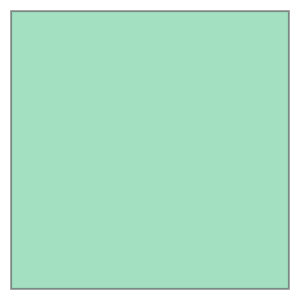

In [31]:
# just get first polygon for testing
first_value = list(cyclone_extent.values())[0]

In [8]:
# before cyclone mangrove canopy cover datasets, group by time
bc_datasets = dc.group_datasets(bc_datasets, group_by='time')
# find all datasets for mangrove canopy cover after cyclone
ac_datasets = dc.find_datasets(product = 'ga_ls_mangrove_cover_cyear_3',time=time_after_cyclone, geopolygon=geobox)
# after cyclone mangrove canopy cover datasets, group by time
ac_datasets = dc.group_datasets(ac_datasets, group_by='time')

In [45]:
dataset.time

<xarray.DataArray 'time' (time: 1)>
array(['2011-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01

In [41]:
cyclone_datasets = dc.group_datasets([dataset], group_by='time')

AttributeError: 'Dataset' object has no attribute 'center_time'

In [32]:
# get polygon extent of cyclone # just using first value for testing
loading_polygon = first_value.intersection(geobox.to_crs(value.crs))
# get bounding box of polygon with 25m res
loading_box = geometry.GeoBox.from_geopolygon(loading_polygon, resolution=(25, -25))

### damage_level_by_geo function

In [72]:
### for function ###
cyclone_data = dataset

In [73]:
c = cyclone_data.transpose('time', 'x', 'y')

In [79]:
cyclone_data.dims

Frozen({'y': 12147, 'x': 7977, 'time': 1})

In [58]:
bc_canopy

<xarray.Dataset>
Dimensions:             (time: 1, y: 3391, x: 1999)
Coordinates:
  * time                (time) datetime64[ns] 2010-07-02T11:59:59.999999
  * y                   (y) float64 -2.197e+06 -2.197e+06 ... -2.112e+06
  * x                   (x) float64 1.586e+06 1.586e+06 ... 1.536e+06 1.536e+06
    spatial_ref         int32 3577
Data variables:
    canopy_cover_class  (time, y, x) int16 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

In [ ]:
    # measurements for windfield data
    measurement = [Measurement(name='wind_speed', dtype='float32', nodata=0, units='1')]
    # load windfield data (was indexed into dev dc)
    cyclone_data = dc.load_data(cyclone_datasets, geobox = loading_box, measurements=measurement)
    # measurements for mangrove canopy cover
    measurement = [Measurement(name='canopy_cover_class', dtype='int16', nodata=-1, units='1')]
    # load mangrove canopy cover from find.datasets that are before the cyclone
    bc_canopy = dc.load_data(bc_datasets, geobox = loading_box, measurements=measurement)
    
    immediate = 0

In [36]:
# measurements for mangrove canopy cover
measurement = [Measurement(name='canopy_cover_class', dtype='int16', nodata=-1, units='1')]
# load mangrove canopy cover from find.datasets that are before the cyclone
bc_canopy = dc.load_data(bc_datasets, geobox = loading_box, measurements=measurement)

immediate = 0

In [83]:
bc_canopy.geobox

GeoBox(1999, 3391, Affine(-25.0, 0.0, 1585975.0,
       0.0, 25.0, -2196775.0), PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]])

In [80]:
cyclone_data_masked = cyclone_data.where(bc_canopy)

In [84]:
cyclone_data.geobox

GeoBox(7977, 12147, Affine(25.0, 0.0, 1386546.6767869953,
       0.0, -24.999999999999982, -1893080.9084511374), +init=epsg:3577)